In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

LogData = pd.read_csv('Data/diabetes.csv')
LogData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


2. Clean the data and remove missing values. Drop any column that is not categorical or numeric. Separate the independent variables from the dependent variables.

In [67]:
print(LogData['Pregnancies'].unique())
print(LogData['Age'].unique())
print(LogData['Outcome'].unique())


[ 6  1  8  0  5  3 10  2  4  7  9 11 13 15 17 12 14]
[50 31 32 21 33 30 26 29 53 54 34 57 59 51 27 41 43 22 38 60 28 45 35 46
 56 37 48 40 25 24 58 42 44 39 36 23 61 69 62 55 65 47 52 66 49 63 67 72
 81 64 70 68]
[1 0]


In [68]:
LogData.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Looks like some problems with unrealistic zero values for Glucose, BloodPressure, Skinthickness, Insulin, and BMI. 

In [69]:
print(LogData.shape)
print(f"Glucose: {(LogData['Glucose'] == 0).sum()}")
print(f"BloodPressure: {(LogData['BloodPressure'] == 0).sum()}")
print(f"SkinThickness: {(LogData['SkinThickness'] == 0).sum()}")
print(f"Insulin: {(LogData['Insulin'] == 0).sum()}")
print(f"BMI: {(LogData['BMI'] == 0).sum()}")


(768, 9)
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11


Almost half of the Insulin values are zero. They are probably all non-values. Let's just remove that column. It's not valid to try to impute.

In [70]:
LogData.drop('Insulin', axis=1, inplace=True)

In [71]:
count=0
for idx, row in LogData.iterrows():
    if ((row['Glucose'] == 0) & (row['BloodPressure'] == 0) 
        & (row['SkinThickness'] == 0) & (row['BMI'] == 0)):
        count += 1
print(count)


0


There are no rows where all of these are zero at once.

Impute the zero values in those columns to the mean.

In [72]:
from sklearn.impute import SimpleImputer
import numpy as np

cols = ('Glucose', 'BloodPressure', 'SkinThickness', 'BMI')

## Impute the numerical values to the mean
imp_mean = SimpleImputer(missing_values=0, strategy='mean')
for col in cols:
    LogData[col] = imp_mean.fit_transform(LogData[col].to_numpy().reshape(-1, 1))

print(LogData.describe())


       Pregnancies     Glucose  BloodPressure  SkinThickness         BMI  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.686763      72.405184      29.153420   32.457464   
std       3.369578   30.435949      12.096346       8.790942    6.875151   
min       0.000000   44.000000      24.000000       7.000000   18.200000   
25%       1.000000   99.750000      64.000000      25.000000   27.500000   
50%       3.000000  117.000000      72.202592      29.153420   32.400000   
75%       6.000000  140.250000      80.000000      32.000000   36.600000   
max      17.000000  199.000000     122.000000      99.000000   67.100000   

       DiabetesPedigreeFunction         Age     Outcome  
count                768.000000  768.000000  768.000000  
mean                   0.471876   33.240885    0.348958  
std                    0.331329   11.760232    0.476951  
min                    0.078000   21.000000    0.000000  
25%                    0.

Let's check to see if there are outlier problems in any of the columns

In [73]:
# loop through all of the numeric columns to check for outliers outside of the
# 3 std deviation range.
for name, values in LogData.select_dtypes(('float64', 'int64')).iteritems():
    mean = pd.Series.mean(values)
    stddev = pd.Series.std(values)
    upper = mean + 3*stddev
    lower = mean - 3*stddev
    print(name)
    print(f"Mean/Std Dev: {mean}, {stddev}")
    print(f"Upper/Lower: {upper} to {lower}")
    OutOfBounds = []
    for idx, value in enumerate(values):
        # If we have outliers add them to the list to print
        # Also, do a winsorizing by setting them to the nearest boundary.
        if not pd.isna(value):
            if (value > upper):
                OutOfBounds.append(value)
                #songsData[name].iloc[idx] = upper
            elif (value < lower):
                OutOfBounds.append(value)
              #  songsData[name].iloc[idx] = lower

    print(f"Outliers: {OutOfBounds}")


Pregnancies
Mean/Std Dev: 3.8450520833333335, 3.3695780626988623
Upper/Lower: 13.953786271429921 to -6.263682104763253
Outliers: [15, 17, 14, 14]
Glucose
Mean/Std Dev: 121.68676277850587, 30.43594886720766
Upper/Lower: 212.99460938012885 to 30.378916176882882
Outliers: []
BloodPressure
Mean/Std Dev: 72.40518417462486, 12.096346184037948
Upper/Lower: 108.6942227267387 to 36.11614562251102
Outliers: [30.0, 110.0, 122.0, 30.0, 110.0, 110.0, 24.0, 114.0]
SkinThickness
Mean/Std Dev: 29.153419593345607, 8.79094192562453
Upper/Lower: 55.5262453702192 to 2.7805938164720168
Outliers: [60.0, 56.0, 63.0, 99.0]
BMI
Mean/Std Dev: 32.457463672391, 6.8751513275037786
Upper/Lower: 53.08291765490233 to 11.832009689879666
Outliers: [53.2, 55.0, 67.1, 59.4, 57.3]
DiabetesPedigreeFunction
Mean/Std Dev: 0.4718763020833327, 0.33132859501277484
Upper/Lower: 1.4658620871216572 to -0.5221094829549917
Outliers: [2.288, 1.893, 1.781, 2.329, 1.476, 2.137, 1.731, 1.6, 2.42, 1.699, 1.698]
Age
Mean/Std Dev: 33.24088

The one that looks to be a problem are the outliers in Bloodpressure. The values on the upper end are dangerously high. It's likely that someone mistakenly entered the systolic bloodpressure instead of the dystolic bloodpressure. Set them to zero and impute them with the mean value for the column.

In [74]:
for idx, value in enumerate(LogData['BloodPressure']):
    if not pd.isna(value):
        mean = pd.Series.mean(LogData['BloodPressure'])
        stddev = pd.Series.std(LogData['BloodPressure'])
        upper = mean + 3*stddev
        if (value > upper):
            OutOfBounds.append(value)
            LogData['BloodPressure'].iloc[idx] = 0

## Impute the numerical values to the mean
imp_mean = SimpleImputer(missing_values=0, strategy='mean')
LogData['BloodPressure'] = imp_mean.fit_transform(
    LogData['BloodPressure'].to_numpy().reshape(-1, 1))

print(LogData['BloodPressure'].describe())


count    768.000000
mean      72.137852
std       11.630124
min       24.000000
25%       64.000000
50%       72.068926
75%       80.000000
max      108.000000
Name: BloodPressure, dtype: float64


D:\Users\Darrell\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


3. Generate dummy variables for the categorical features.

There are no categorical features in this dataset. The only categorical value is Outcome which is the dependent variable (target). 

4. Create a training set that's 75% of your data set and a complementary test set with the remaining 25%. Specify random_state=0.

In [75]:
from sklearn.model_selection import train_test_split

X = LogData.drop('Outcome', axis=1)
y = LogData['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)


5. Train the model using the LogisticRegressionCV class, which has cross-validation capability built in. Use this to tune your Cs hyperparameter. What value of this hyperparameter performs best in cross-validation?

In [76]:
from sklearn.linear_model import LogisticRegressionCV

regLogit = LogisticRegressionCV().fit(X_train, y_train)
print(f"Final C hyperparameter: {regLogit.C_}")
      
# Check on the testing dataset
print(f"Score: {regLogit.score(X_test, y_test)}")



Final C hyperparameter: [0.35938137]
Score: 0.78125


In [77]:
predictions_test = regLogit.predict(X_test)
residuals_test = predictions_test - y_test


Do some evaluation of the model.
1. Get the confusion matrix

In [79]:
from sklearn.metrics import confusion_matrix

print("Confusion Matrix")
print(confusion_matrix(y_test, predictions_test))

Confusion Matrix
[[117  13]
 [ 29  33]]


2. Plot the ROC curve

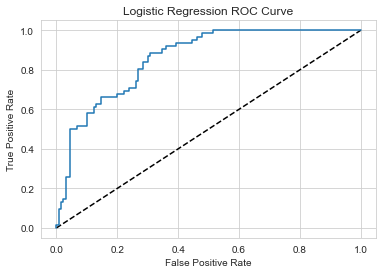

In [80]:
from sklearn.metrics import roc_curve
y_pred_prob = regLogit.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

3. Calculate the AUC ROC

In [83]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
print(f"AUC: {roc_auc_score(y_test, y_pred_prob)}")

# Compute the cross-validation AUC scores
cv_auc = cross_val_score(regLogit, X, y, cv=5, scoring='roc_auc')
print(f"AUC scores computed using 5-fold cross-validation:{cv_auc}")


AUC: 0.8568238213399504


D:\Users\Darrell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC scores computer using 5-fold cross-validation:[0.81351852 0.80018519 0.85888889 0.88396226 0.84018868]


Try this all again by normalizing the numeric columns to get them all in a similar range. (Annie's idea to do better)